In [1]:
import numpy as np
import scipy.optimize as opt
import sys, os, random, gzip
import tensorflow as tf
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [337]:
# global flags & parameters
# remark: increase the sample size for full deployment, while the training/testing samples should be skipped.
SRC_SIG = {'filename':'jet_g_match_qcd_gg.txt.gz', 'skip':60000, 'n':2000}
SRC_BKG = {'filename':'jet_q_match_qcd_qq.txt.gz', 'skip':60000, 'n':2000}
WEIGHTS_2PCNN = 'wgts_prototype.h5'
BATCH_SIZE = 80
MAKE_SUMMARY_PLOTS = True
EPOCHS = 20
ENABLE_EARLY_STOPPING = True
MAX_PATIENCE = 10

# # constituents format
# _index, _type, _pid, _charge, _pt, _eta, _phi, _vx, _vy, _vz = range(10)
_pt,_eta,_phi=1,2,3 #myfile use pt in index 1, eta->2,phi->3
def deltaPhi(phi1,phi2):
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x

def deltaR(eta1,phi1,eta2,phi2):
    return (deltaPhi(phi1,phi2)**2+(eta1-eta2)**2)**0.5

def find_main_axis(clist):
    def fcn(p):
        dir_x,dir_y = np.cos(p[0]),np.sin(p[0])
        v = clist[(clist[:,_eta]**2+clist[:,_phi]**2)**0.5>1E-5]
        cosang = np.abs(dir_x*v[:,_eta]+dir_y*v[:,_phi])/(v[:,_eta]**2+v[:,_phi]**2)**0.5
        proj = (v[:,_pt]*cosang).sum()
        return -proj
    r = opt.minimize(fcn,[0.])
    if r.success: return r.x[0]
    else: return None

# reading jet data from the gzipped text stream
# def parse_jet_data(fin):
    
#     if '<jet_data>' not in fin.readline().decode():
#         print(">>> ERROR: invalid input", flush=True)
#         sys.exit(0)
#     data = {}
#     buf = fin.readline().decode().split() # jet kinematics
#     data['index'] = int(buf[0])
#     data['pt'] = float(buf[1])
#     data['eta'] = float(buf[2])
#     data['phi'] = float(buf[3])
#     data['mass'] = float(buf[4])
#     data['deltaeta'] = float(buf[5])
#     data['deltaphi'] = float(buf[6])
#     data['charge'] = int(buf[7])
#     data['ehadovereem'] = float(buf[8])
#     data['ncharged'] = int(buf[9])
#     data['nneutrals'] = int(buf[10])
#     data['tau1'] = float(buf[11])
#     data['tau2'] = float(buf[12])
#     data['tau3'] = float(buf[13])
#     data['tau4'] = float(buf[14])
#     data['tau5'] = float(buf[15])
#     buf = fin.readline().decode().split() # trimmed/pruned/softdrop P4
#     data['pt_trimmed'] = float(buf[0])
#     data['eta_trimmed'] = float(buf[1])
#     data['phi_trimmed'] = float(buf[2])
#     data['mass_trimmed'] = float(buf[3])
#     data['pt_pruned'] = float(buf[4])
#     data['eta_pruned'] = float(buf[5])
#     data['phi_pruned'] = float(buf[6])
#     data['mass_pruned'] = float(buf[7])
#     data['pt_pruned_sub1'] = float(buf[8])
#     data['eta_pruned_sub1'] = float(buf[9])
#     data['phi_pruned_sub1'] = float(buf[10])
#     data['mass_pruned_sub1'] = float(buf[11])
#     data['pt_pruned_sub2'] = float(buf[12])
#     data['eta_pruned_sub2'] = float(buf[13])
#     data['phi_pruned_sub2'] = float(buf[14])
#     data['mass_pruned_sub2'] = float(buf[15])
#     data['pt_pruned_sub3'] = float(buf[16])
#     data['eta_pruned_sub3'] = float(buf[17])
#     data['phi_pruned_sub3'] = float(buf[18])
#     data['mass_pruned_sub3'] = float(buf[19])
#     data['pt_softdrop'] = float(buf[20])
#     data['eta_softdrop'] = float(buf[21])
#     data['phi_softdrop'] = float(buf[22])
#     data['mass_softdrop'] = float(buf[23])
#     data['pt_softdrop_sub1'] = float(buf[24])
#     data['eta_softdrop_sub1'] = float(buf[25])
#     data['phi_softdrop_sub1'] = float(buf[26])
#     data['mass_softdrop_sub1'] = float(buf[27])
#     data['pt_softdrop_sub2'] = float(buf[28])
#     data['eta_softdrop_sub2'] = float(buf[29])
#     data['phi_softdrop_sub2'] = float(buf[30])
#     data['mass_softdrop_sub2'] = float(buf[31])
#     data['pt_softdrop_sub3'] = float(buf[32])
#     data['eta_softdrop_sub3'] = float(buf[33])
#     data['phi_softdrop_sub3'] = float(buf[34])
#     data['mass_softdrop_sub3'] = float(buf[35])
#     buf = fin.readline().decode().split() # subject/constituents counts
#     data['nsub_trimmed'] = int(buf[0])
#     data['nsub_pruned'] = int(buf[1])
#     data['nsub_softdrop'] = int(buf[2])
#     data['nconstituents'] = int(buf[3])
#     buf = fin.readline().decode().split() # generater info
#     data['gen_pid'] = int(buf[0])
#     data['gen_charge'] = int(buf[1])
#     data['gen_pt'] = float(buf[2])
#     data['gen_eta'] = float(buf[3])
#     data['gen_phi'] = float(buf[4])
#     data['gen_mass'] = float(buf[5])
  

  
#      clist = [] # prepare constituents list
#     for i in range(data['nconstituents']):
#         var = [float(s) for s in fin.readline().decode().split()] # index, type(0:gen/1:track/2:Ecal/3:Hcal), pid, charge, pt, eta, phi, vx, vy, vz
#         # relative to jet pt and direction
#         var[_pt ] = var[_pt]/data['pt']
#         var[_eta] = var[_eta]-data['eta']
#         var[_phi] = deltaPhi(var[_phi],data['phi'])
#         clist.append(var)
#     clist = np.array(clist)

#     buf = fin.readline().decode().split() # Tjet variables, nsub = 1
#     data['tjet1_eta1'] = float(buf[0])
#     data['tjet1_phi1'] = float(buf[1])
#     buf = fin.readline().decode().split()
#     data['tjet1_R1'] = float(buf[0])
#     data['tjet1_R1_pt1'] = float(buf[1])
#     data['tjet1_R1_m1'] = float(buf[2])
#     buf = fin.readline().decode().split()
#     data['tjet1_R2'] = float(buf[0])
#     data['tjet1_R2_pt1'] = float(buf[1])
#     data['tjet1_R2_m1'] = float(buf[2])
#     buf = fin.readline().decode().split()
#     data['tjet1_R3'] = float(buf[0])
#     data['tjet1_R3_pt1'] = float(buf[1])
#     data['tjet1_R3_m1'] = float(buf[2])
#     buf = fin.readline().decode().split()
#     data['tjet1_R4'] = float(buf[0])
#     data['tjet1_R4_pt1'] = float(buf[1])
#     data['tjet1_R4_m1'] = float(buf[2])

#     buf = fin.readline().decode().split() # Tjet variables, nsub = 2
#     data['tjet2_eta1'] = float(buf[0])
#     data['tjet2_phi1'] = float(buf[1])
#     buf = fin.readline().decode().split()
#     data['tjet2_eta2'] = float(buf[0])
#     data['tjet2_phi2'] = float(buf[1])
#     buf = fin.readline().decode().split()
#     data['tjet2_R1'] = float(buf[0])
#     data['tjet2_R1_pt1'] = float(buf[1])
#     data['tjet2_R1_pt2'] = float(buf[2])
#     data['tjet2_R1_m1'] = float(buf[3])
#     data['tjet2_R1_m2'] = float(buf[4])
#     buf = fin.readline().decode().split()
#     data['tjet2_R2'] = float(buf[0])
#     data['tjet2_R2_pt1'] = float(buf[1])
#     data['tjet2_R2_pt2'] = float(buf[2])
#     data['tjet2_R2_m1'] = float(buf[3])
#     data['tjet2_R2_m2'] = float(buf[4])
#     buf = fin.readline().decode().split()
#     data['tjet2_R3'] = float(buf[0])
#     data['tjet2_R3_pt1'] = float(buf[1])
#     data['tjet2_R3_pt2'] = float(buf[2])
#     data['tjet2_R3_m1'] = float(buf[3])
#     data['tjet2_R3_m2'] = float(buf[4])
#     buf = fin.readline().decode().split()
#     data['tjet2_R4'] = float(buf[0])
#     data['tjet2_R4_pt1'] = float(buf[1])
#     data['tjet2_R4_pt2'] = float(buf[2])
#     data['tjet2_R4_m1'] = float(buf[3])
#     data['tjet2_R4_m2'] = float(buf[4])

#     buf = fin.readline().decode().split() # Tjet variables, nsub = 3
#     data['tjet3_eta1'] = float(buf[0])
#     data['tjet3_phi1'] = float(buf[1])
#     buf = fin.readline().decode().split()
#     data['tjet3_eta2'] = float(buf[0])
#     data['tjet3_phi2'] = float(buf[1])
#     buf = fin.readline().decode().split()
#     data['tjet3_eta3'] = float(buf[0])
#     data['tjet3_phi3'] = float(buf[1])
#     buf = fin.readline().decode().split()
#     data['tjet3_R1'] = float(buf[0])
#     data['tjet3_R1_pt1'] = float(buf[1])
#     data['tjet3_R1_pt2'] = float(buf[2])
#     data['tjet3_R1_pt3'] = float(buf[3])
#     data['tjet3_R1_m1'] = float(buf[4])
#     data['tjet3_R1_m2'] = float(buf[5])
#     data['tjet3_R1_m3'] = float(buf[6])
#     buf = fin.readline().decode().split()
#     data['tjet3_R2'] = float(buf[0])
#     data['tjet3_R2_pt1'] = float(buf[1])
#     data['tjet3_R2_pt2'] = float(buf[2])
#     data['tjet3_R2_pt3'] = float(buf[3])
#     data['tjet3_R2_m1'] = float(buf[4])
#     data['tjet3_R2_m2'] = float(buf[5])
#     data['tjet3_R2_m3'] = float(buf[6])
#     buf = fin.readline().decode().split()
#     data['tjet3_R3'] = float(buf[0])
#     data['tjet3_R3_pt1'] = float(buf[1])
#     data['tjet3_R3_pt2'] = float(buf[2])
#     data['tjet3_R3_pt3'] = float(buf[3])
#     data['tjet3_R3_m1'] = float(buf[4])
#     data['tjet3_R3_m2'] = float(buf[5])
#     data['tjet3_R3_m3'] = float(buf[6])
#     buf = fin.readline().decode().split()
#     data['tjet3_R4'] = float(buf[0])
#     data['tjet3_R4_pt1'] = float(buf[1])
#     data['tjet3_R4_pt2'] = float(buf[2])
#     data['tjet3_R4_pt3'] = float(buf[3])
#     data['tjet3_R4_m1'] = float(buf[4])
#     data['tjet3_R4_m2'] = float(buf[5])
#     data['tjet3_R4_m3'] = float(buf[6])

#     if '</jet_data>' not in fin.readline().decode():
#         print(">>> ERROR: invalid input", flush=True)
#         sys.exit(0)
    
#     # Apply rotation
#     dir = find_main_axis(clist)
#     if dir!=None:
#         dir = -dir # rotation everything to x-axis
#         clist[:,_eta], clist[:,_phi] = np.cos(dir)*clist[:,_eta]-np.sin(dir)*clist[:,_phi], np.sin(dir)*clist[:,_eta]+np.cos(dir)*clist[:,_phi]

#     return data, clist

# skip 1 set of jet data from the gzipped text stream
def skip_jet_data(fin):
    if '<jet_data>' not in fin.readline().decode():
        print(">>> ERROR: invalid input", flush=True)
        sys.exit(0)
    while '</jet_data>' not in fin.readline().decode():
        pass

def prepare_sample(filename, size, skip = 0):
    fin = gzip.open(filename)
    print('Loading from',filename, flush=True)
    
    if skip>0:
        print('Skip first',skip,'jets', flush=True)
        for i in range(skip):
            skip_jet_data(fin)
    
    slist = []
    while(len(slist)<size):
        d, c = parse_jet_data(fin)
        if len(c)<4: continue # drop those jets with low # of constituents
        
        # inject regular jet data for convenience
        supply = np.array([d['pt']/1E3, # in unit of TeV
                           d['eta'],
                           d['phi']],dtype=K.floatx())
        
        c_ext = [] # expend the 2-particle correlations
        for i,j in [(i,j) for i in range(len(c)) for j in range(i+1,len(c))]:
            
            # only (pt,eta,phi)*2
            c_ext.append([c[i,_pt],c[i,_eta],c[i,_phi],
                          c[j,_pt],c[j,_eta],c[j,_phi]])

        slist.append((np.array(c_ext,dtype=K.floatx()),supply)) # tuple of 2pc array, supply array
        if len(slist) % 1000==0: print(len(slist),'/',size,'jets loaded', flush=True)
    fin.close()
    return slist

# custom 2PC layer
class MyLayer(Layer):

    def __init__(self, filters, toppooling_dim = 1, hidden_dim = None, **kwargs):
        self.filters = filters
        self.toppooling_dim = toppooling_dim
        self.hidden_dim = hidden_dim
        super(MyLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        if self.hidden_dim!=None:
            self.w1 = self.add_weight(name='w1', shape=(self.filters, input_shape[-1], self.hidden_dim), initializer='normal', trainable=True)
            self.b1 = self.add_weight(name='b1', shape=(self.filters, self.hidden_dim), initializer='normal', trainable=True)
            self.w2 = self.add_weight(name='w2', shape=(self.filters, self.hidden_dim, 1), initializer='normal', trainable=True)
            self.b2 = self.add_weight(name='b2', shape=(self.filters, 1), initializer='normal', trainable=True)
        else:
            self.w1 = self.add_weight(name='w1', shape=(self.filters, input_shape[-1], 1), initializer='normal', trainable=True)
            self.b1 = self.add_weight(name='b1', shape=(self.filters, 1), initializer='normal', trainable=True)
        
        super(MyLayer, self).build(input_shape)
    
    def call(self, x):
        def operation_over_sample(sample):
            buffer = []
            for idx in range(self.filters):
                oper = K.dot(sample,self.w1[idx])+self.b1[idx] # sum w*x+b
                oper = K.relu(oper) # activation
                
                if self.hidden_dim!=None: # insert hidden dense layer
                    oper = K.dot(oper,self.w2[idx])+self.b2[idx] # sum w*x+b
                    oper = K.relu(oper) # activation
                
                # since the first input is pt, which is always positive => convert it as a mask
                mask = K.expand_dims(K.greater(sample[:,0],0.),axis=1)
                mask = K.cast(mask,K.floatx())
                oper *= mask # apply masking
                
                top_indices = tf.nn.top_k(oper[:,0], k=self.toppooling_dim, sorted=True).indices
                top = K.gather(oper,top_indices) # top-k pooling
                
                buffer.append(top)
            return K.concatenate(buffer)
        return K.map_fn(operation_over_sample,x)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.toppooling_dim, self.filters) # output dimension = n_samples x toppooling_dim x filters
def combine2(a):
    return a*(a-1)/2
def txttogz(myev): ## txt -> .txt.gz
    import gzip
    
    import shutil
    with open(myev, 'rb') as f_in, gzip.open(myev+'.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
def parse_jet_data(fin):
    
#     if '<jet_data>' not in fin.readline().decode():
#         print(">>> ERROR: invalid input", flush=True)
#         sys.exit(0)
    data = {}
    fin.readline().decode().split()
    buf = fin.readline().decode().split() # jet kinematics
    data['pt'] = float(buf[1])
    data['eta'] = float(buf[2])
    data['phi'] = float(buf[3])
    data['nconstituents'] = int(buf[4])
    fin.readline().decode().split()
    clist = [] # prepare constituents list
    for i in range(data['nconstituents']):
        var = [float(s) for s in fin.readline().decode().split()] # index, type(0:gen/1:track/2:Ecal/3:Hcal), pid, charge, pt, eta, phi, vx, vy, vz
        # relative to jet pt and direction
        _pt,_eta,_phi=1,2,3 #myfile use pt in index 1, eta->2,phi->3
        var[_pt ] = var[_pt]/data['pt']
        var[_eta] = var[_eta]-data['eta']
        var[_phi] = deltaPhi(var[_phi],data['phi'])
        clist.append(var)
    clist = np.array(clist)
    dir = find_main_axis(clist)
    if dir!=None:
        dir = -dir # rotation everything to x-axis
        clist[:,_eta], clist[:,_phi] = np.cos(dir)*clist[:,_eta]-np.sin(dir)*clist[:,_phi], np.sin(dir)*clist[:,_eta]+np.cos(dir)*clist[:,_phi]


    return data, clist
def prepare_sample2(filename, size, skip = 0):
    fin = gzip.open(filename)
    print('Loading from',filename, flush=True)
    
#     if skip>0:
#         print('Skip first',skip,'jets', flush=True)
#         for i in range(skip):
#             skip_jet_data(fin)
    
    slist = []
    while(len(slist)<size):
        d, c = parse_jet_data(fin)
        if len(c)<4: continue # drop those jets with low # of constituents
        
        # inject regular jet data for convenience
        supply = np.array([d['pt']/1E3, # in unit of TeV
                           d['eta'],
                           d['phi']],dtype=K.floatx())
        
        c_ext = [] # expend the 2-particle correlations
        for i,j in [(i,j) for i in range(len(c)) for j in range(i+1,len(c))]:
            
            # only (pt,eta,phi)*2
            c_ext.append([c[i,_pt],c[i,_eta],c[i,_phi],
                          c[j,_pt],c[j,_eta],c[j,_phi]])

        slist.append((np.array(c_ext,dtype=K.floatx()),supply)) # tuple of 2pc array, supply array
        if len(slist) % 1000==0: print(len(slist),'/',size,'jets loaded', flush=True)
    fin.close()
    return slist

In [338]:
def parse_jet_data_myself(fin):
    
#     if '<jet_data>' not in fin.readline().decode():
#         print(">>> ERROR: invalid input", flush=True)
#         sys.exit(0)
    data = {}
    fin.readline().decode().split()
    buf = fin.readline().decode().split() # jet kinematics
    data['e'] = float(buf[0])
    data['pt'] = float(buf[1])
    data['eta'] = float(buf[2])
    data['phi'] = float(buf[3])
    data['nconstituents'] = int(buf[4])
    fin.readline().decode().split()
    clist = [] # prepare constituents list
    for i in range(data['nconstituents']):
        var = [float(s) for s in fin.readline().decode().split()] # index, type(0:gen/1:track/2:Ecal/3:Hcal), pid, charge, pt, eta, phi, vx, vy, vz
        # relative to jet pt and direction
        _e,_pt,_eta,_phi=0,1,2,3 #myfile use pt in index 1, eta->2,phi->3
#         var[_pt ] = var[_pt]/data['pt']
#         var[_eta] = var[_eta]-data['eta']
#         var[_phi] = deltaPhi(var[_phi],data['phi'])
        clist.append(var)
    clist = np.array(clist)
#     dir = find_main_axis(clist)
#     if dir!=None:
#         dir = -dir # rotation everything to x-axis
#         clist[:,_eta], clist[:,_phi] = np.cos(dir)*clist[:,_eta]-np.sin(dir)*clist[:,_phi], np.sin(dir)*clist[:,_eta]+np.cos(dir)*clist[:,_phi]


    return data, clist
def prepare_sample_myself(filename, size, skip = 0):
    fin = gzip.open(filename)
    print('Loading from',filename, flush=True)
    
#     if skip>0:
#         print('Skip first',skip,'jets', flush=True)
#         for i in range(skip):
#             skip_jet_data(fin)
    
    slist, jetlist = [], []
    while(len(slist)<size):
        d, c = parse_jet_data_myself(fin)
        if len(c)<4: continue # drop those jets with low # of constituents
        
        # inject regular jet data for convenience
        
#         supply = np.array([d['pt']/1E3, # in unit of TeV
#                            d['eta'],
#                            d['phi']],dtype=K.floatx())
        supply = [d['e'],d['pt'],d['eta'],d['phi']]
        jetlist.append(supply)
#         c_ext = [] # expend the 2-particle correlations
#         for i,j in [(i,j) for i in range(len(c)) for j in range(i+1,len(c))]:
            
#             # only (pt,eta,phi)*2
#             c_ext.append([c[i,_pt],c[i,_eta],c[i,_phi],
#                           c[j,_pt],c[j,_eta],c[j,_phi]])

        slist.append(c) # tuple of 2pc array, supply array
        if len(slist) % 1000==0: print(len(slist),'/',size,'jets loaded', flush=True)
    fin.close()
    return jetlist, slist

In [339]:
##data prepare myself
myev='./myevents'
qq,gg='qq','gg'

In [340]:
## you need it only for first times you run this program
txttogz(myev+qq+'.txt') ##txt -> gz
txttogz(myev+gg+'.txt')

In [341]:
nEvent = 5000
jet_sig, slist_sig,=prepare_sample_myself(myev+gg+'.txt.gz', nEvent, skip = 0)
jet_bkg, slist_bkg=prepare_sample_myself(myev+qq+'.txt.gz', nEvent, skip = 0)
sample = [[*s,np.array([1.,0.],dtype=K.floatx())] for s in slist_sig]+[[*s,np.array([0.,1.],dtype=K.floatx())] for s in slist_bkg]

Loading from ./myeventsgg.txt.gz
1000 / 5000 jets loaded
2000 / 5000 jets loaded
3000 / 5000 jets loaded
4000 / 5000 jets loaded
5000 / 5000 jets loaded
Loading from ./myeventsqq.txt.gz
1000 / 5000 jets loaded
2000 / 5000 jets loaded
3000 / 5000 jets loaded
4000 / 5000 jets loaded
5000 / 5000 jets loaded


In [111]:
slist_sig[0][0]

array([ 1.33597   ,  0.00230321, -0.39034509, -0.01626397])

In [345]:
def mydeltaphi(p1,p2):
    phi = p1-p2
    if phi<np.pi:
        phi+2*np.pi
    if phi>=np.pi:
        phi-2*np.pi
    return phi

def dij(vec1, vec2, R=0.4, jetpt=-1,w=1,d=1):
    distance = ((vec1[2]-vec2[2])**2+mydeltaphi(vec1[3],vec2[3])**2)**0.5/R
    distance = distance**d
    if (jetpt!=-1):
        weight = max(vec1[1],vec2[1])/jetpt
        distance = distance*weight**w    
    return distance
def edgeset(vec,RCUT,R=0.4,jetpt=-1,w=1,d=1):
    points = len(vec)
    edge = [set([i,j]) for i in range(1,points) for j in range(i) if dij(vec[i], vec[j], R, jetpt, w, d)<=RCUT]
    points = set([i for i in range(points)])
    return points, edge 
def neighborhood(vec,k=-1,R=0.4,jetpt=-1,w=1,d=1):
    points = len(vec)
    if k == -1:
        k = points
    if k > points:
        print("You need check k > number of particles")
    else:
        dijset = [[dij(vec[i], vec[j], R, jetpt, w, d) for j in range(points)] for i in range(points)]
        x = []
        index0 = [i for i in range(points)]
        for i in range(points):
            edges = np.sort(dijset[i])
            index = []
            for j in edges[:k+1]:
                index.append(index0[dijset[i].index(j)])
            x.append(index)
        
        points = set([i for i in range(points)])
        return points, x 
# def neighborset(points, x):
#     a = set([j for i in points for j in x if i in j])
#     [ for i in a]
                

In [104]:
n=36
x, y, c = [], [], [] 
vec = [i for i in jet_sig[n]]
vec[1] = 0
for i in range(len(slist_sig[n])):
    x.append(np.log2(dij(vec, slist_sig[n][i], jetpt=jet_sig[n][1], w=1, d=0)))
    y.append(dij(jet_sig[n], slist_sig[n][i], R=1, w=0, d=1))
    c.append(slist_sig[n][i][1])

In [79]:
slist_sig[n][1], jet_sig[n]

(array([ 0.913314,  0.600641, -0.96484 ,  2.95111 ]),
 [943.404, 533.897, -1.17012, 2.76041])

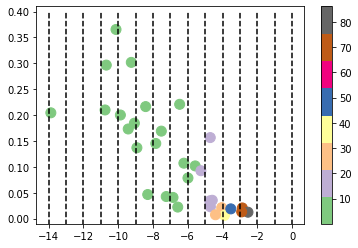

In [105]:
sc = plt.scatter(x,y,s=100,c=c,cmap='Accent')
k=2-int(min(x))
for i in range(k):
    plt.plot([-i,-i],[-0.1,0.4], '--', c='black')
plt.ylim((-0.01,0.41))
plt.colorbar(sc)

In [308]:
dcut = r/2 # in range(1/10000,1/1000)
n = 98
P, E = neighborhood(slist_bkg[n] , k = 1, jetpt = jet_bkg[n][1], w=-2, d=2)


In [99]:
for n in range(100):
    P, E = neighborhood(slist_sig[n] , k = 1, jetpt = jet_sig[n][1], w=-2, d=2)
    aaa = [i[1] for i in E]
    if len(set(aaa))==2:
        print(n)
del aaa

12
35
57
63
91
92


In [309]:
E

[[0, 24],
 [1, 24],
 [2, 24],
 [3, 24],
 [4, 24],
 [5, 24],
 [6, 24],
 [7, 24],
 [8, 24],
 [9, 24],
 [10, 24],
 [11, 24],
 [12, 24],
 [13, 24],
 [14, 24],
 [15, 24],
 [16, 24],
 [17, 24],
 [18, 24],
 [19, 24],
 [20, 24],
 [21, 24],
 [22, 24],
 [23, 24],
 [24, 25],
 [25, 24]]

In [193]:
P, E = edgeset(slist_sig[0], dcut,jetpt = jet_sig[0][1], w=w, d=d)

2

In [7]:
nEvent = 21
def edge_analy(nEvent, slist_sig, slist_bkg, jet_sig, jet_bkg, rcut=-1, output= False , a=1, b=1):
    dcut = 0
    P, E = edgeset(slist_sig[nEvent],dcut,jetpt= jet_sig[nEvent][1], w=a, d=b)
    P2, E2 = edgeset(slist_bkg[nEvent],dcut,jetpt= jet_bkg[nEvent][1], w=a, d=b)
    n=len(P)
    n2=len(P2)
    if (output):
        print('total N =',n,'  ',n2)
        n=n*(n-1)/2
        n2=n2*(n2-1)/2
        print('total edge =',n,'  ',n2)
        print('=====================================================edge_rcut/edge_total=========================')
        print('RCUT    ', 'sig        ', 'bkg')
        if rcut==-1:
            for i in range(150):
                delta = 0.00001
                dcut = delta*i
                P, E = edgeset(slist_sig[nEvent],dcut,jetpt = jet_sig[nEvent][1], w=a, d=b)
                P2, E2 = edgeset(slist_bkg[nEvent],dcut,jetpt = jet_bkg[nEvent][1], w=a, d=b)
                if (i%10==0):
                    print(round(dcut,5),'  ', round(len(E)/n*100,3),'%','  ', round(len(E2)/n2*100,3),'%')
    if rcut!=-1:
        n=n*(n-1)/2
        n2=n2*(n2-1)/2
        dcut = rcut
        P, E = edgeset(slist_sig[nEvent],dcut, jetpt = jet_sig[nEvent][1], w=a, d=b)
        P2, E2 = edgeset(slist_bkg[nEvent],dcut, jetpt = jet_bkg[nEvent][1], w=a, d=b)
        if (output):
            print(round(dcut,5),'  ', round(len(E)/n*100,3),'%','  ', round(len(E2)/n2*100,3),'%')
        return len(E)/n, len(E2)/n2

In [116]:
len(slist_sig)

5000

/home/james/.conda/envs/test2/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/james/.conda/envs/test2/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


(array([3.8177072, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 3.8177072, 3.8177072,
        7.6354144, 0.       , 0.       , 0.       , 7.6354144, 0.       ,
        0.       , 0.       , 0.       , 0.       , 3.8177072, 7.6354144,
        3.8177072, 3.8177072, 0.       , 3.8177072, 3.8177072, 7.6354144,
        3.8177072, 0.       , 0.       , 3.8177072, 3.8177072, 0.       ,
        0.       , 0.       , 0.       , 3.8177072, 0.       , 0.       ,
        0.       , 3.8177072]),
 array([0.35164835, 0.36412156, 0.37659476, 0.38906797, 0.40154117,
        0.41401438, 0.42648759, 0.43896079, 0.451434  , 0.4639072 ,
        0.47638041, 0.48885362, 0.50132682, 0.51380003, 0.52627323,
        0.53874644, 0.55121964, 0.56369285, 0.57616606, 0.58863926,
        0.60111247, 0.61358567, 0.62605888, 0.63853209, 0.65100529,
        0.6634785 , 0.6759517 , 0.68

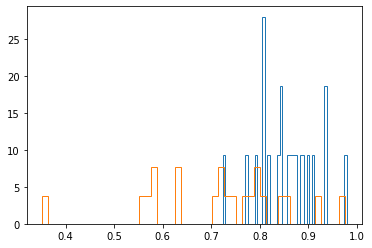

In [115]:
#analy data
x, y = [], []
for iEvent in range(nEvent):
#     r=0.000003001
    sig, bkg =edge_analy(iEvent, slist_sig, slist_bkg, jet_sig, jet_bkg, rcut=r,a=w,b=d)
    x.append(sig)
    y.append(bkg)
plt.hist(x, histtype='step', normed=True, bins=50)
plt.hist(y, histtype='step', normed=True, bins=50)

In [153]:
1+1

2

In [8]:
def within(lwb,upb,j):
    if (upb<=j)&(j<lwb):
        return True
    else:
        return False
    
def myLoss(r=0.000003,w=1,d=1,bins=50, slist_sig=slist_sig, slist_bkg=slist_bkg, jet_sig=jet_sig, jet_bkg=jet_bkg):
    sig, bkg = [], []
    nEvent = len(slist_sig)
    for iEvent in range(nEvent):
        x, y = edge_analy(iEvent, slist_sig, slist_bkg, jet_sig, jet_bkg, rcut=r,a=w,b=d)
        sig.append(x)
        bkg.append(y)
#     lwb, upb = max(sig+bkg), min(sig+bkg)
    lwb, upb = 1, 0
    deltax = (lwb - upb)/bins
    L = sum([abs(len([0 for j in sig if within(upb+deltax*(i+1),upb+deltax*i,j)])-
                 len([0 for j in bkg if within(upb+deltax*(i+1),upb+deltax*i,j)])) for i in range(bins)])
    L = 1-L/(len(sig)+len(bkg))
    return L

def direct(r,w,d, deltad=1,deltaw=1,deltar=1/1E6, x=slist_sig, y=slist_bkg, xj=jet_sig, yj=jet_bkg):
    a = [-1,0,1]
    vec = [[r+i*deltar,w+j*deltaw,d+k*deltad]for i in a for j in a for k in a]
    L0 = myLoss(r,w,d,slist_sig=x, slist_bkg=y, jet_sig=xj, jet_bkg=yj)
    Ls=L0
    for i in vec:
        L = myLoss(i[0],i[1],i[2],slist_sig=x, slist_bkg=y, jet_sig=xj, jet_bkg=yj)
        if L0>L:
            L0 = L
            r, w, d = i[0],i[1],i[2]
    return r, w, d, L0
        
def batch(x=slist_sig,size=1):
    n = len(x)
    a = [[x[i] for i in range (n) if within((j+1)*size,j*size,i)] for j in range(n//size) ]
    return a
    
    
    

# def mygradient(r,w,d,deltad=1,deltaw=1,deltar=1/1E9):
    
#     L = myLoss(r=r,w=w,d=d)
    
    
    
    
    
    
    

In [ ]:

count=0
L=100
w, d =3, 3
r=(1/100)**w*(1/10)**d
deltar=r/10
deltaw=0.5
deltad=0.5
N=len(x)
for i in range(N):
    if count >10:
        break
    r0, w0, d0, L0 = direct(r, w, d, deltar=deltar, deltaw=deltaw, deltad=deltad, x=x[i], y=y[i], xj=xj[i], yj=yj[i])
    deltar = (1/100)**w0*(1/10)**d0
    L0 = myLoss(r0,w0,d0)
    print(i,'LOSS= ',L0,'r, w, d = ', r0, w0, d0)
#     if L<L0:
#         break
    if L<=L0:
        deltar = deltar/2
        deltaw = deltaw/2
        deltad = deltad*(1/100)**deltaw*(1/10)**deltad
        count=count+1
        continue
    r,w,d=r0,w0,d0
    L = L0

In [9]:
x=batch(slist_sig,size=100)
y=batch(slist_bkg,size=100)
xj=batch(jet_sig,size=100)
yj=batch(jet_bkg,size=100)

In [109]:

N=len(x)
L=L0
for i in range(N):
    r, w, d, L0 = direct(r, w, d, x=x[i], y=y[i], xj=xj[i], yj=yj[i])
    print(i,'LOSS= ',L0,'r, w, d = ', r, w, d)
    if L<L0:
        break
    if i==0:
        L = L0
    

In [147]:
r,w,d

(1.032522776601684e-06, 1.5, 1.5)

In [23]:
i=0
{i|i in range(10)}
{i for i in range(10)}

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [98]:
(1 in [1,2])&(3 in [1,2])

False

In [7]:
slist_sig[0][0]

array([1.33597 , 1.26606 , 0.313192, 4.03542 ])

In [8]:
jet_sig[0]

[646.789, 549.694, 0.576217, 4.3243]

In [ ]:
#r, w, d = (1.032522776601684e-06, 1.5, 1.5)

In [28]:
tf.random.normal((5,1), mean=1, stddev=1.0, dtype=tf.float32)

<tf.Operation 'PrintV2_4' type=PrintV2>

In [ ]:
tf.random.uniform(
    shape, minval=0, maxval=None, dtype=tf.dtypes.float32, seed=None, name=None
)

In [41]:
w1 = tf.Variable(tf.random.uniform([2, 3], minval=0, maxval=1), trainable=True, constraint = tf.keras.constraints.MaxNorm(max_value=1, axis=0) )

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    print(w1)
    print(sess.run(w1))



<tf.Variable 'Variable_4:0' shape=(2, 3) dtype=float32_ref>
[[0.22401321 0.45938468 0.8032191 ]
 [0.69169486 0.05838752 0.17943871]]


In [450]:
def mapping_2d(x,y,x0= 0 , y0 = 0, bins = (28,28)):
    deltax = (x-x0)/bins[0]
    X = tf.range(x0, x, deltax)
    deltay = (y-y0)/bins[1]
    Y = tf.range(y0, y, deltay)
    X = tf.expand_dims(X, axis  = 1)
    Y = tf.expand_dims(Y, axis  = 0)
    X = tf.tile(X, [1,bins[1]])
    X = tf.expand_dims(X, axis  = -1)
    Y = tf.tile(Y, [bins[0],1])
    Y = tf.expand_dims(Y, axis  = -1)
    coordinate = tf.concat([X,Y], axis=-1)
    return coordinate 
def index_0(bins = (28,28)):
    X = tf.range(0, bins[0], 1)
    Y = tf.range(0, bins[1], 1)
    X =tf.expand_dims(X, axis  = 1)
    Y = tf.expand_dims(Y, axis  = 0)
    X = tf.tile(X, [1,bins[1]])
    X =tf.expand_dims(X, axis  = -1)
    Y = tf.tile(Y, [bins[0],1])
    Y = tf.expand_dims(Y, axis  = -1)
    index = tf.concat([X,Y], axis=-1)
    return index
def map_index(x, xlm, x0, c, bins = (28,28)):
    x = tf.cast(x, tf.float64, name=None)
    c = tf.cast(c, tf.float64, name=None)
    indexs = [c[0],c[1],0]
    deltax = (xlm[0]-x0[0])/bins[0]
    deltay = (xlm[1]-x0[1])/bins[1]
    condi = tf.reduce_all([tf.math.greater_equal(x[0], c[0]), tf.math.less(x[0], c[0]+deltax),tf.math.greater_equal(x[1], c[1])  ,tf.math.less( x[1] , c[1]+deltay)])
    indexs[2] = tf.cond(condi, lambda: x[2], lambda: tf.constant(0, dtype = tf.float64 ))
    
    indexs = tf.cast(indexs, tf.float32)
            
    return indexs

def my_map_coor2d(x, xlm = tf.constant([0,0.4]), x0 = tf.constant([-14,0]), d=2, bins = [28,28], dtype = tf.float32):
    b0 = bins[0]
    x = tf.cast(x, dtype , name=None)
#     c = tf.cast(c, dtype , name=None)
#     D = tf.range(0,d,1)
#     D = tf.cast(D, tf.int8, name=None)
    
    xlm = tf.cast(xlm, dtype )
    x0 = tf.cast(x0, dtype )
    bins = tf.constant(bins)
    bins = tf.cast(bins, dtype )
    delta = (xlm - x0)/bins
    bins = tf.cast(bins, tf.int8)
    
    coor0 = tf.convert_to_tensor([tf.range(x0[0], xlm[0], delta[0])])
    def cond(i, d, coor0):
        return  i< d
    def body(i, d , coor0):
        x =  tf.range(x0[i], xlm[i], delta[i])
        coor0 = tf.concat([coor0, [tf.range(x0[i], xlm[i], delta[i])]], 0) 
        i = i+1
        return i, d, coor0
    i = tf.constant(1)
    td = tf.constant(d)
    _, _, coor0 = tf.while_loop(cond, body, [i, td , coor0], shape_invariants=[i.get_shape(), td.get_shape(), tf.TensorShape([None,b0])] )
    
    
#     condi = tf.reduce_all([tf.math.greater_equal(x[0], c[0]), tf.math.less(x[0], c[0]+deltax),tf.math.greater_equal(x[1], c[1])  ,tf.math.less( x[1] , c[1]+deltay)])
#     indexs[2] = tf.cond(condi, lambda: x[2], lambda: tf.constant(0, dtype = tf.float64 ))
    
#     indexs = tf.cast(indexs, tf.float32)
            
    return coor0

def map_coor( xlm = tf.constant([0,0.4]), x0 = tf.constant([-14,0]), d=2, bins = [28,28], dtype = tf.float32):
    b0 = bins[0]
    
    xlm = tf.cast(xlm, dtype )
    x0 = tf.cast(x0, dtype )
    bins = tf.constant(bins)
    bins = tf.cast(bins, dtype )
    delta = (xlm - x0)/bins
    bins = tf.cast(bins, tf.int8)
    
    coor0 = tf.ragged.range(x0,xlm,deltas = delta )

            
    return coor0

def within(x,c, delta):
    xb = tf.math.logical_and(tf.math.greater_equal(x[0],c[0,:]), tf.math.less(x[0],c[0,:]+delta[0]))
    yb = tf.math.logical_and(tf.math.greater_equal(x[1],c[1,:]), tf.math.less(x[1],c[1,:]+delta[1]))
    return(tf.math.logical_and(xb,yb))

def within_ind(x,c):
    xb = tf.math.greater_equal(x[0],c[0,:])
    xb = tf.cast(xb, tf.int8 )
    xb = tf.math.reduce_sum(xb) -1
    yb = tf.math.greater_equal(x[1],c[1,:])
    yb = tf.cast(yb, tf.int8 )
    yb = tf.math.reduce_sum(yb) -1
    
    return xb, yb

def map_coor2(x, xlm = tf.constant([0,0.4]), x0 = tf.constant([-14,0]), d=2, bins = [28,28], dtype = tf.float32):
    b0 = bins[0]
    
    xlm = tf.cast(xlm, dtype )
    x0 = tf.cast(x0, dtype )
    bins = tf.constant(bins)
    bins = tf.cast(bins, dtype )
    delta = (xlm - x0)/bins
    coor0 = tf.ragged.range(x0,xlm,deltas = delta )
   
    
    return  within(x,coor0,delta)


In [305]:
# inputs = tf.constant([[[1, 2, 3], [2, 3, 4]],
#                      [[3, 4,5], [4, 5, 6]],
#                      [[5, 6, 7], [6, 7, 8]]])
# data = tf.slice(inputs, [1, 0, 0], [1, 1, 3])
dtype = tf.float32
xlm = tf.constant([1,1])
xlm = tf.cast(xlm, dtype )
x0 = tf.constant([0,0])
x0 = tf.cast(x0, dtype )
bins = tf.constant((28,28))
bins = tf.cast(bins, dtype )
delta = (xlm - x0)/bins
D = tf.range(0,2,1)
bins = (28,28)
d = 2


In [423]:
bins = [28,28]
coor0 = map_coor()
a = tf.constant([[-11,0.1,1/64],[-10.1,0.34,1/32],[-5.2,0.2,10]])
acx = a[:,0]
coor0 = map_coor()
af = tf.zeros([1,bins[0]])
aup = tf.math.greater_equal(acx, coor0[0])

In [428]:
X = coor0[0]
Y = coor0[1]
X =tf.expand_dims(X, axis  = 1)
Y = tf.expand_dims(Y, axis  = 0)
X = tf.tile(X, [1,bins[1]])
X =tf.expand_dims(X, axis  = -1)
Y = tf.tile(Y, [bins[0],1])
Y = tf.expand_dims(Y, axis  = -1)
index = tf.concat([X,Y], axis=-1)



In [467]:
coor0[0].get_shape()

TensorShape([Dimension(None)])

In [433]:

a = tf.constant([[-11,0.1,1/64],[-10.1,0.34,1/32],[-5.2,0.2,10]])
x = a
a2 = tf.constant([[-11,0.1,1/64],[-10.1,.34,1/3],[-5.2,.2,11]])
index = tf.constant(0)
coor0x = coor0[0]
coor0y = coor0[1]
coor0 = tf.convert_to_tensor(coor0)
def cond(i, d, coor0x,  coor0y, index, x):
    return  i< d
def body(i, d , coor0x,  coor0y, index, x):
    index = within_ind(x[i],coor0y)
    i = i+1
    return i, d, coor0x, coor0y, index
i = tf.constant(0)
td = tf.constant(tf.shape(x)[0])
_, _, _, _, ind = tf.while_loop(cond, body, [i, td , coor0x,  coor0y, index, x], shape_invariants=[i.get_shape(), td.get_shape(), coor0x.get_shape(), coor0y.get_shape(),
                                                                                                tf.TensorShape([None,2]), tf.constant(a).get_shape()]  )
    

<tf.Tensor 'LogicalAnd_5:0' shape=(3,) dtype=bool>

In [464]:
a = tf.constant([[-11,0.1,1/64],[-10.1,0.34,1/32],[-5.2,0.2,10]])
a = tf.shape(a)[0]

In [438]:
coor0[0]

tf.RaggedTensor(values=Tensor("RaggedRange_24:1", shape=(?,), dtype=float32), row_splits=Tensor("RaggedRange_24:0", shape=(3,), dtype=int64))

In [465]:
sess = tf.Session()
print(sess.run(a))
sess.close()

3


In [321]:
dtype = tf.float32
xlm = tf.constant([0,0.4])
xlm = tf.cast(xlm, dtype )
x0 = tf.constant([-12,0])
x0 = tf.cast(x0, dtype )
bins = tf.constant((28,28))
bins = tf.cast(bins, dtype )
delta = (xlm - x0)/bins
a = tf.ragged.range(x0,xlm,deltas = delta )


In [335]:

a = map_coor(1)
a =  my_map_coor2d(1)

In [304]:
tf.nest.assert_same_structure(
coor0, coor2, check_types=True, expand_composites=False
)

In [306]:

coor2 = tf.concat([coor0, [tf.range(x0[i], xlm[i], delta[i])]], 0)
coor2

<tf.Tensor 'concat_54:0' shape=(2, 28) dtype=float32>

[[-11.     0.1 ]
 [-10.1    0.34]
 [ -5.2    0.2 ]]


In [165]:
d = tf.constant(2)
d.get_shape()

TensorShape([])

In [307]:

# x =  tf.range()
# coor0 = tf.tile()
# i = 0
# coor0 = tf.concat([ coor0, tf.range(x0[i], xlm[i], delta[i]) ], 0)

In [308]:
sess = tf.Session()
print(sess.run(coor0))
sess.close()

[[-12.         -11.571428   -11.142857   -10.714285   -10.285713
   -9.8571415   -9.42857     -8.999998    -8.571426    -8.142855
   -7.7142835   -7.2857122   -6.857141    -6.42857     -5.9999986
   -5.5714273   -5.142856    -4.714285    -4.2857137   -3.8571422
   -3.4285707   -2.9999993   -2.5714278   -2.1428564   -1.7142849
   -1.2857134   -0.857142    -0.42857054]
 [  0.           0.01428571   0.02857143   0.04285714   0.05714286
    0.07142857   0.08571429   0.1          0.11428571   0.12857144
    0.14285715   0.15714286   0.17142858   0.18571429   0.2
    0.21428572   0.22857143   0.24285714   0.25714287   0.27142859
    0.2857143    0.3          0.31428573   0.32857144   0.34285715
    0.35714287   0.37142858   0.3857143 ]]


In [15]:
dtype = tf.float32
xlm = tf.constant([0,0.4])
xlm = tf.cast(xlm, dtype )
x0 = tf.constant([-12,0])
x0 = tf.cast(x0, dtype )
bins = tf.constant((28,28))
bins = tf.cast(bins, dtype )
delta = (xlm - x0)/bins

In [13]:
def nmapping_2d(x,y,x0= 0 , y0 = 0, bins = (28,28)):
    deltax = (x-x0)/bins[0]
    X =np.arange(x0, x, deltax)
    deltay = (y-y0)/bins[1]
    Y = np.arange(y0, y, deltay)
    X =np.expand_dims(X, axis  = 1)
    Y = np.expand_dims(Y, axis  = 0)
    X = np.tile(X, [1,bins[1]])
    X =np.expand_dims(X, axis  = -1)
    Y = np.tile(Y, [bins[0],1])
    Y = np.expand_dims(Y, axis  = -1)
    coordinate = np.concatenate([X,Y], axis=-1)
    return coordinate 


In [16]:
def map_index(x, xlm, x0, c, bins = (28,28)):
    indexs = [c[0],c[1],0]
    deltax = (xlm[0]-x0[0])/bins[0]
    deltay = (xlm[1]-x0[1])/bins[1]
    if (x[0] >= c[0])&(x[0] < c[0]+deltax):
        if (x[1] >= c[1])&(x[1] < c[1]+deltay):
            indexs[2] = x[2]
    return indexs

In [ ]:
# tf.math.greater 
# tf.math.greater_equal
# tf.math.less
# tf.math.less_equal
# tf.math.equal

# sess = tf.Session()
# print(sess.run( ))

In [25]:
def index_0(bins = (28,28)):
    X = np.arange(0, bins[0], 1)
    Y = np.arange(0, bins[1], 1)
    X =np.expand_dims(X, axis  = 1)
    Y = np.expand_dims(Y, axis  = 0)
    X = np.tile(X, [1,bins[1]])
    X =np.expand_dims(X, axis  = -1)
    Y = np.tile(Y, [bins[0],1])
    Y = np.expand_dims(Y, axis  = -1)
    index = np.concatenate([X,Y], axis=-1)
    return index
def map_out(x, xlm , x0, c , bins = (28,28)):
    
    
    

In [157]:
sess = tf.Session()
print(sess.run(a))
sess.close()

In [164]:
x = tf.constant([0.15,0.25,10])
c = tf.constant([0.1,0.2])
bins = (10,10)
x = tf.cast(x, tf.float64, name=None)
c = tf.cast(c, tf.float64, name=None)
indexs = [c[0],c[1],0]
deltax = (xlm[0]-x0[0])/bins[0]
deltay = (xlm[1]-x0[1])/bins[1]

xlm = tf.constant([1,1])
x0 = tf.constant([0,0])
# map_index(x, xlm, x0, c, bins = (28,28))
sess = tf.Session()
print(sess.run(map_index(x, xlm, x0, c, bins = (28,28))))
sess.close()
# sess = tf.Session()
# print(sess.run(map_index(x, xlm, x0, c, bins = (28,28))))

[0.1 0.2 0. ]


In [73]:

sess = tf.Session()
# Evaluate the tensor `c`.
print(sess.run(index_0()))


[[[ 0  0]
  [ 0  1]
  [ 0  2]
  ...
  [ 0 25]
  [ 0 26]
  [ 0 27]]

 [[ 1  0]
  [ 1  1]
  [ 1  2]
  ...
  [ 1 25]
  [ 1 26]
  [ 1 27]]

 [[ 2  0]
  [ 2  1]
  [ 2  2]
  ...
  [ 2 25]
  [ 2 26]
  [ 2 27]]

 ...

 [[25  0]
  [25  1]
  [25  2]
  ...
  [25 25]
  [25 26]
  [25 27]]

 [[26  0]
  [26  1]
  [26  2]
  ...
  [26 25]
  [26 26]
  [26 27]]

 [[27  0]
  [27  1]
  [27  2]
  ...
  [27 25]
  [27 26]
  [27 27]]]


In [68]:
a = tf.constant([[1,3],[2,4]])
tf.math.equal(a,1)

<tf.Tensor 'Equal_15:0' shape=(2, 2) dtype=bool>

In [63]:
a = tf.constant([1,2,3,4,5])
b = tf.constant([1,6,3,8,5])
def f1():
    return 0
def f2():
    return 1

tf.cond(tf.reduce_all(tf.math.equal(a, b)) , f1, f2)

<tf.Tensor 'cond_19/Merge:0' shape=() dtype=int32>

In [59]:
x = tf.constant(2)
y = tf.constant(5)
def f1(): return tf.multiply(x, 1)
def f2(): return tf.add(y, 1)
sess.run(tf.cond(tf.less(x, y), f1, f2))
# r is set to f1().
# Operations in f2 (e.g., tf.add) are not executed.

2

In [3]:
a = np.array([1,23,12])
np.where(a==1)

(array([0]),)

In [18]:
a = nmapping_2d(1,1,x0= 0 , y0 = 0, bins = (10,10))
x = np.random.uniform(size = [10,3])

map_index(x[0], [1,1], [0,0] ,a[1][2], bins = (10,10))


[0.1, 0.2, 0]

array([[8.50040726e-01, 6.79147283e-01, 2.55494052e-02],
       [6.77361313e-01, 8.38640056e-01, 5.41238173e-01],
       [5.55156623e-01, 6.81651984e-01, 5.50494936e-01],
       [1.21648840e-01, 2.14299324e-01, 9.45851414e-01],
       [1.17311814e-01, 8.73045571e-01, 2.36399931e-01],
       [1.40243940e-01, 9.47430221e-01, 8.44760650e-02],
       [2.83558383e-03, 6.43274760e-01, 5.50864885e-01],
       [3.49723941e-01, 5.62772739e-01, 4.19591240e-01],
       [1.60370360e-01, 2.42454823e-01, 8.86389211e-05],
       [3.78788600e-01, 2.20756554e-01, 3.73375013e-01]])

In [78]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())


    print(a)
    

FailedPreconditionError: Attempting to use uninitialized value Variable_5
	 [[node Variable_5/read (defined at <ipython-input-70-a5e7bb94337c>:1) ]]

Original stack trace for 'Variable_5/read':
  File "/home/james/.conda/envs/test2/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/james/.conda/envs/test2/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/james/.conda/envs/test2/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/james/.conda/envs/test2/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/james/.conda/envs/test2/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-70-a5e7bb94337c>", line 1, in <module>
    a = tf.Variable(a, trainable=True, constraint = tf.keras.constraints.MaxNorm(max_value=1, axis=0) )
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 1568, in __init__
    shape=shape)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 1755, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 86, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4253, in identity
    "Identity", input=input, name=name)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/james/.conda/envs/test2/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [49]:

x = [[1,2,3],[4,5,6]]
y = [[7,8,9],[10,11,12]]
condition3 = [[True,False,False],
             [False,True,True]]
condition4 = [[True,False,False],
             [True,True,False]]
coordinate = [[[0,0],[0,1],[0,2]],[[1,0],[1,1],[1,2]]]

if condition3:
    a = coordinate
    print(a)



[[[0, 0], [0, 1], [0, 2]], [[1, 0], [1, 1], [1, 2]]]


In [10]:
a = tf.Variable( initial_value=None,trainable=True, constraint=None )

ValueError: initial_value must be specified.